## Описание проекта

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.
Значение метрики RMSE на тестовой выборке должно быть не больше 48.

### Инструкция по выполнению проекта

1. Загрузите данные и выполните их ресемплирование по одному часу.
2. Проанализируйте данные.
3. Обучите разные модели с различными гиперпараметрами. Сделайте тестовую выборку размером 10% от исходных данных.
4. Проверьте данные на тестовой выборке и сделайте выводы.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from statsmodels.iolib.table import SimpleTable

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from catboost import Pool, CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.dummy import DummyRegressor

from sklearn.model_selection import cross_val_score
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RepeatedKFold

## Подготовка

In [2]:
try:
    data = pd.read_csv('/datasets/taxi.csv')
except:
    data = pd.read_csv('C:/Users/Mikhail/оформление/Прогнозирование заказов такси/taxi.csv')

In [3]:
data.head(), data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


(              datetime  num_orders
 0  2018-03-01 00:00:00           9
 1  2018-03-01 00:10:00          14
 2  2018-03-01 00:20:00          28
 3  2018-03-01 00:30:00          20
 4  2018-03-01 00:40:00          32,
 None)

проверка изменения типа данных

In [4]:
data['datetime'] = data['datetime'].astype('datetime64')
data.info(), data.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    26496 non-null  datetime64[ns]
 1   num_orders  26496 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 414.1 KB


(None, (26496, 2))

проверим данные на дупликаты

In [5]:
data.duplicated()

0        False
1        False
2        False
3        False
4        False
         ...  
26491    False
26492    False
26493    False
26494    False
26495    False
Length: 26496, dtype: bool

In [6]:
data.drop_duplicates(keep="first", inplace=True)
data.shape

(26496, 2)

Дупликатов не нашлось

In [7]:
data = data.set_index('datetime')
data = data.sort_index()
data.index.is_monotonic, data.shape

(True, (26496, 1))

дата сет монотонный, в хронологическом порядке.

In [8]:
data_day = data.resample('1D').sum()

<AxesSubplot:xlabel='datetime'>

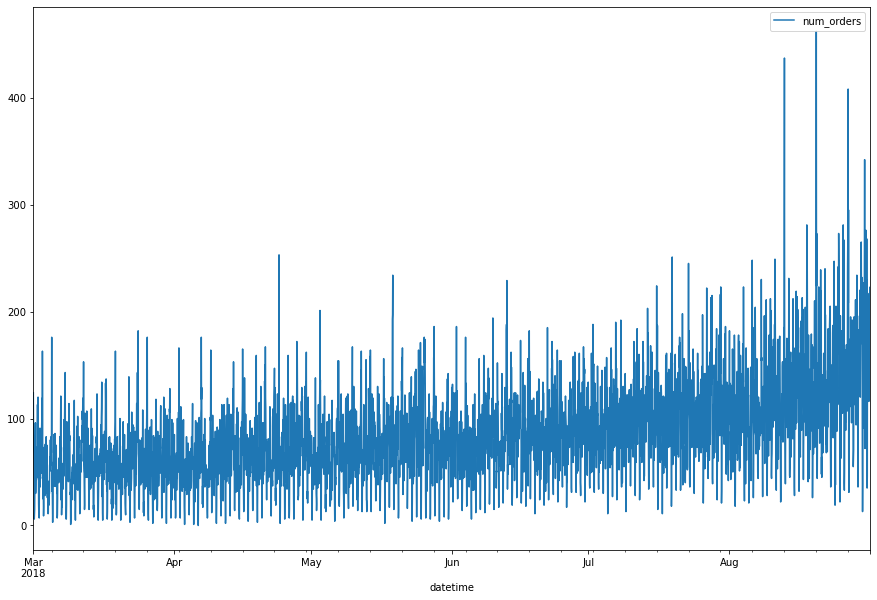

In [9]:
data = data.resample('1H').sum()
data.plot(figsize=(15, 10))

Многие методы и модели основаны на предположениях о стационарности ряда,поэтому для проверки проверки стационарности давайте проведем обобщенный тест Дикки-Фуллера на наличие единичных корней. Для этого в модуле statsmodels есть функция adfuller():

In [10]:
test = sm.tsa.adfuller(data)
print ('adf: ', test[0])
print ('p-value: ', test[1])
print ('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print ('есть единичные корни, ряд не стационарен')
else:
    print ('единичных корней нет, ряд стационарен')

adf:  -3.068924289027937
p-value:  0.028940051402614374
Critical values:  {'1%': -3.431842162413052, '5%': -2.8621993540813637, '10%': -2.567120978470452}
единичных корней нет, ряд стационарен


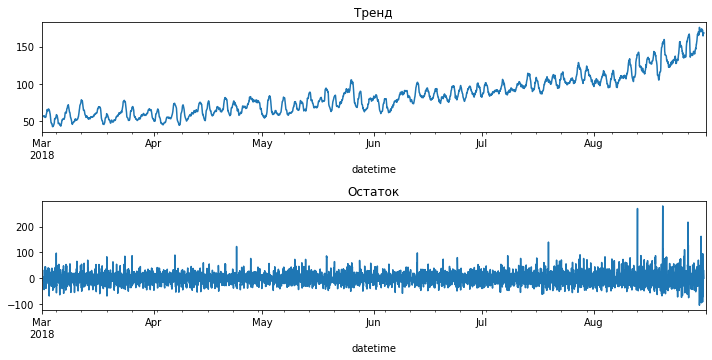

In [16]:
decomposed = seasonal_decompose(data)

plt.figure(figsize=(6, 8))
plt.subplot(311)

# Чтобы график корректно отобразился, указываем его
# оси ax, равными plt.gca() (англ. get current axis,
# получить текущие оси)
decomposed.trend.plot(ax=plt.gca(), figsize=(10, 7))
plt.title('Тренд')
plt.subplot(312)
decomposed.resid .plot(ax=plt.gca(), figsize=(10, 7))
# < напишите код здесь >
plt.title('Остаток')
plt.tight_layout()

1. Тренд идет к росту числа заказов, в плане созонности можно посмотреть график заказов в течение недели.

In [18]:
data_new = pd.DataFrame(data=data)

In [19]:
def make_features(data, max_lag, rolling_mean_size, data_new):
    data_new['day'] = data.index.day
    data_new['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data_new['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data_new['rolling_mean'] = data['num_orders'].shift(1).rolling(rolling_mean_size).mean()
    data_new['rolling_sum'] = data['num_orders'].shift(1).rolling(rolling_mean_size).sum()
    
    return data_new
    
    

## Обучение

In [20]:
make_features(data, 24, 5, data_new)

,num_orders,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean,rolling_sum
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,1,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,1,3,124.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,1,3,85.0,124.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,1,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,1,3,66.0,71.0,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,31,4,207.0,217.0,197.0,116.0,133.0,166.0,136.0,...,230.0,194.0,276.0,246.0,158.0,198.0,142.0,72.0,174.0,870.0
2018-08-31 20:00:00,154,31,4,136.0,207.0,217.0,197.0,116.0,133.0,166.0,...,99.0,230.0,194.0,276.0,246.0,158.0,198.0,142.0,174.6,873.0
2018-08-31 21:00:00,159,31,4,154.0,136.0,207.0,217.0,197.0,116.0,133.0,...,268.0,99.0,230.0,194.0,276.0,246.0,158.0,198.0,182.2,911.0


Эксперемнтальным путем было определено, что при таких значениях модель выдает лучший показатель rmse

In [21]:
data.shape

(4416, 29)

In [22]:
train, valid = train_test_split(data_new, shuffle=False, test_size=0.32)
valid, test = train_test_split(valid, shuffle=False, test_size=0.29)
train = train.dropna()
train.shape,valid.shape, test.shape

((2978, 29), (1003, 29), (411, 29))

Таким образом мы разбили датасет на трейн\валид в отношении 75%\25%, и 10% датасета ушло тестовую часть

In [23]:
target_train = train['num_orders']
features_train = train.drop('num_orders', axis=1)

target_valid = valid['num_orders']
features_valid = valid.drop('num_orders', axis=1)

target_test = test['num_orders']
features_test = test.drop('num_orders', axis=1)

target_train.shape, features_train.shape, target_valid.shape, features_valid.shape, target_test.shape, features_test.shape

((2978,), (2978, 28), (1003,), (1003, 28), (411,), (411, 28))

### LinearRegression

In [24]:
%%time
model_lr = LinearRegression().fit(features_train, target_train)

y_pred = model_lr.predict(features_valid)
y_true = target_valid

mse = mean_squared_error(y_true, y_pred)
rmse = (mse**0.5).mean()
print('RMSE LinearRegression на валидационной выборке', rmse)

RMSE LinearRegression на валидационной выборке 32.54681419939833
Wall time: 16 ms


### RandomForestRegressor

In [25]:
%%time

best_model = None
best_rmse = 48
for i in range (2, 60, 2):
    model_RFR = RandomForestRegressor(random_state=12345,
                                      n_estimators=100, max_depth=i).fit(features_train, target_train)
    y_true = target_valid
    y_pred = model_RFR.predict(features_valid)
    mse = mean_squared_error(y_true, y_pred)
    rmse = (mse**0.5).mean()
    if rmse < best_rmse:
        best_model = model_RFR
        best_rmse = rmse

print('RMSE модели RandomForestRegressor на валидационной выборке', best_rmse, best_model)

RMSE модели RandomForestRegressor на валидационной выборке 33.4739213442211 RandomForestRegressor(max_depth=26, random_state=12345)
Wall time: 1min 38s


### Ridge

In [26]:
%%time
clf = Ridge(alpha=1.0)
clf.fit(features_train, target_train)

y_pred = clf.predict(features_valid)
y_true = target_valid

mse = mean_squared_error(y_true, y_pred)
rmse = (mse**0.5).mean()
print('RMSE Ridge на валидационной выборке', rmse)

RMSE Ridge на валидационной выборке 32.54653123740728
Wall time: 20 ms


### CatBoostRegressor

In [27]:
%%time

best_model_cb = None
best_rmse_cb = 48
cvTSS = TimeSeriesSplit(max_train_size=None, n_splits=10)

for i in range (2, 16, 2):
    model_CB = CatBoostRegressor(iterations=200, depth=i, loss_function='RMSE',
                                 random_seed=1234, verbose=100).fit(features_train, target_train, cat_features=None, verbose=None)

    y_pred = model_CB.predict(features_valid)
    y_true = target_valid

    mse = mean_squared_error(y_true, y_pred)
    rmse = (mse**0.5).mean()
    if rmse < best_rmse_cb:
        best_model_cb = model_CB
        best_rmse_cb = rmse
        
print('RMSE CatBoostRegressor на валидационной выборке', best_rmse_cb, best_model_cb)

Learning rate set to 0.161056
0:	learn: 32.1397814	total: 157ms	remaining: 31.2s
100:	learn: 20.5673265	total: 263ms	remaining: 258ms
199:	learn: 19.2517881	total: 351ms	remaining: 0us
Learning rate set to 0.161056
0:	learn: 31.7151755	total: 1.51ms	remaining: 300ms
100:	learn: 18.1035773	total: 151ms	remaining: 148ms
199:	learn: 15.5297811	total: 303ms	remaining: 0us
Learning rate set to 0.161056
0:	learn: 31.5808925	total: 4.52ms	remaining: 899ms
100:	learn: 15.4722584	total: 307ms	remaining: 300ms
199:	learn: 11.5453927	total: 595ms	remaining: 0us
Learning rate set to 0.161056
0:	learn: 31.4544957	total: 8.72ms	remaining: 1.74s
100:	learn: 12.4318681	total: 828ms	remaining: 812ms
199:	learn: 7.8836431	total: 1.65s	remaining: 0us
Learning rate set to 0.161056
0:	learn: 31.4614394	total: 36ms	remaining: 7.16s
100:	learn: 8.8305177	total: 3.94s	remaining: 3.86s
199:	learn: 4.2128683	total: 8.3s	remaining: 0us
Learning rate set to 0.161056
0:	learn: 31.4813918	total: 173ms	remaining: 34

### LGBMRegressor

In [28]:
%%time

params = {"learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25] ,
          "max_depth"        : [ 3, 4, 5, 6, 8, 10],
          "min_child_weight" : [ 1, 3, 5, 7 ],
          "gamma"            : [ 0.0, 0.1, 0.2 , 0.3],
          "colsample_bytree" : [ 0.3, 0.4, 0.5 ]}

folds = 15
param_comb = 15
n_iter = 100

cvTSS = TimeSeriesSplit(max_train_size=None, n_splits=10)
model_lgbm = LGBMRegressor(n_estimators=300)

random_search = RandomizedSearchCV(model_lgbm, param_distributions=params, 
                                   n_iter=param_comb, cv=cvTSS, scoring=make_scorer(mean_squared_error), 
                                   n_jobs=-1, verbose=3, random_state=1001 )

model_lgbm = random_search.fit(features_train,target_train)

y_pred = model_lgbm.predict(features_valid)
y_true = target_valid

mse = mean_squared_error(y_true, y_pred)
rmse = (mse**0.5).mean()
print('RMSE LGBMRegressor на валидационной выборке', rmse)

Fitting 10 folds for each of 15 candidates, totalling 150 fits
[LightGBM] [Warning] Unknown parameter: gamma
RMSE LGBMRegressor на валидационной выборке 34.4714169550054
Wall time: 9.52 s


### DummyRegressor для теста на адекватность

In [29]:
%%time
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(features_train,target_train)

y_pred = dummy_regr.predict(features_valid)
y_true = target_valid

mse = mean_squared_error(y_true, y_pred)
rmse = (mse**0.5).mean()
print('RMSE DummyRegressor на валидационной выборке', rmse)

RMSE DummyRegressor на валидационной выборке 53.578867850229805
Wall time: 1 ms


## Анализ моделей

In [30]:
def rmse_on_test (model, test_f, test_t):
    y_true = test_t
    y_pred = model.predict(test_f)
    
    rmse = ((mean_squared_error(y_true, y_pred))**0.5).mean()
    print ('Модель', model)
    print ('RMSE', rmse)
    print(' ')

In [31]:
model_list = [model_lr, best_model, clf, best_model_cb, model_lgbm, dummy_regr]

In [32]:
for model in model_list:
    rmse_on_test(model, features_test, target_test)

Модель LinearRegression()
RMSE 46.61135824595161
 
Модель RandomForestRegressor(max_depth=26, random_state=12345)
RMSE 57.55216661637025
 
Модель Ridge()
RMSE 46.610923564642874
 
Модель <catboost.core.CatBoostRegressor object at 0x0000024A1A182460>
RMSE 57.44350724129417
 
Модель RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=10, test_size=None),
                   estimator=LGBMRegressor(n_estimators=300), n_iter=15,
                   n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.3, 0.4, 0.5],
                                        'gamma': [0.0, 0.1, 0.2, 0.3],
                                        'learning_rate': [0.05, 0.1, 0.15, 0.2,
                                                          0.25],
                                        'max_depth': [3, 4, 5, 6, 8, 10],
                                        'min_child_weight': [1, 3, 5, 7]},
                   random_state=1001, scoring=make_scorer(mean_squared_error)

### Сделаем своднуб таблицу для сравнений

In [33]:
d = {'Model_name': ['RandomForestRegressor', 'LinearRegression', 'CatBoostRegressor', 'LGBMRegressor', 'Ridge', 'DummyRegressor'],
     'RMSE': [56.97, 46.61359239132161, 60.852, 66.1, 46.61, 92.517], 
     'Fit_time_second' : [135, 21.6, 834, 1399, 61, 0.001]}
df = pd.DataFrame(data=d)

In [34]:
df.sort_values(by=['RMSE', 'Fit_time_second'])

,Model_name,RMSE,Fit_time_second
4,Ridge,46.610000,61.000
1,LinearRegression,46.613592,21.600
0,RandomForestRegressor,56.970000,135.000
2,CatBoostRegressor,60.852000,834.000
3,LGBMRegressor,66.100000,1399.000
5,DummyRegressor,92.517000,0.001


1. Только две модели прошли порог RMSE на тестовой части, хоть они все и показали хороший результат на валидации

## Ridge

In [35]:
y_true = target_test
y_pred = clf.predict(features_test)
y_pred_plot = pd.Series(y_pred)
y_true_plot = pd.Series(y_true)

In [36]:
y_true_plot = y_true_plot.reset_index()
y_true_plot['num_orders_pred'] = y_pred_plot
y_true_plot = y_true_plot.set_index('datetime', drop=True)
y_true_plot = y_true_plot.sort_index()
y_true_plot

,num_orders,num_orders_pred
datetime,,
2018-08-14 21:00:00,119,112.350929
2018-08-14 22:00:00,81,112.797717
2018-08-14 23:00:00,212,113.331385
2018-08-15 00:00:00,211,152.762408
2018-08-15 01:00:00,98,199.446390
...,...,...
2018-08-31 19:00:00,136,112.993492
2018-08-31 20:00:00,154,150.487575
2018-08-31 21:00:00,159,180.112105


<AxesSubplot:xlabel='datetime'>

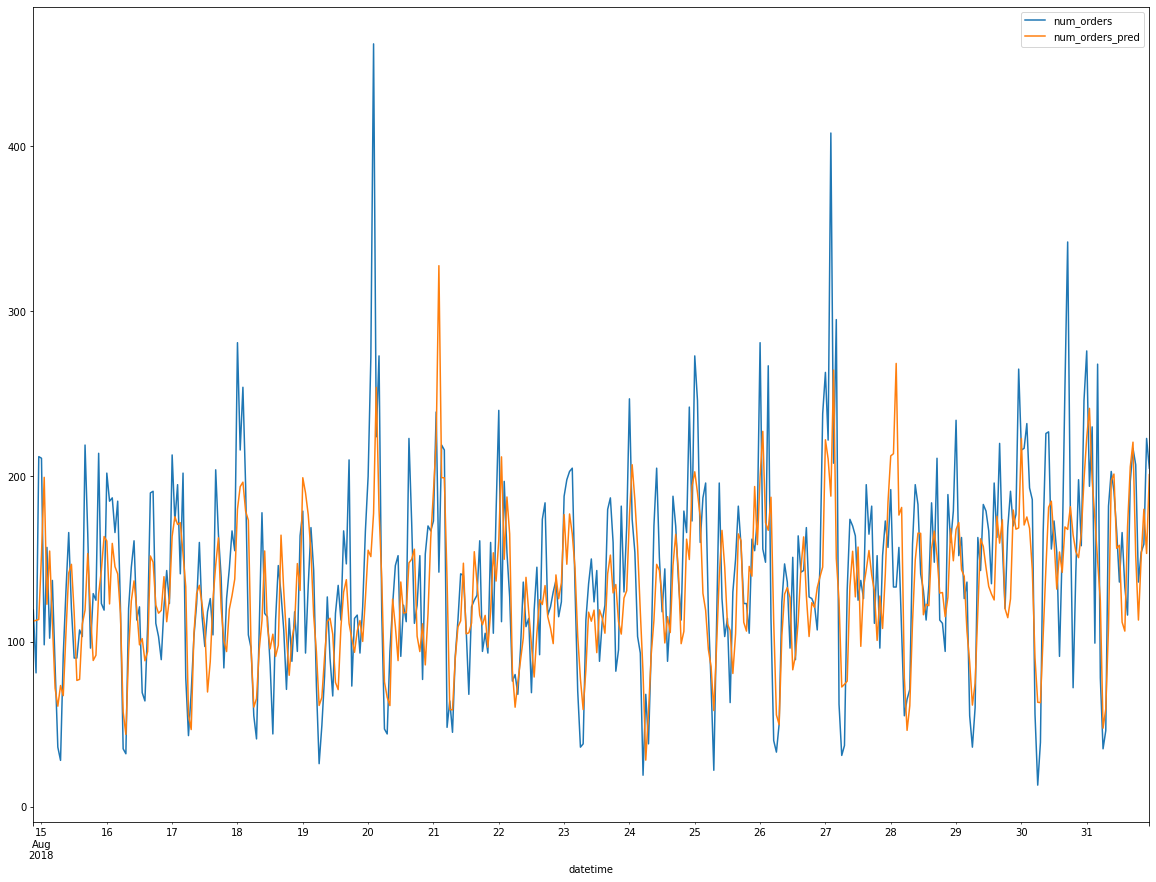

In [37]:
y_true_plot.plot(figsize=(20, 15))

## LinearRegression

In [38]:
y_true = target_test
y_pred = model_lr.predict(features_test)
y_pred_plot = pd.Series(y_pred)
y_true_plot = pd.Series(y_true)

In [39]:
y_true_plot = y_true_plot.reset_index()
y_true_plot['num_orders_pred'] = y_pred_plot
y_true_plot = y_true_plot.set_index('datetime', drop=True)
y_true_plot = y_true_plot.sort_index()
y_true_plot

,num_orders,num_orders_pred
datetime,,
2018-08-14 21:00:00,119,112.337772
2018-08-14 22:00:00,81,112.810062
2018-08-14 23:00:00,212,113.325519
2018-08-15 00:00:00,211,152.774403
2018-08-15 01:00:00,98,199.460163
...,...,...
2018-08-31 19:00:00,136,112.985416
2018-08-31 20:00:00,154,150.486744
2018-08-31 21:00:00,159,180.112934


<AxesSubplot:xlabel='datetime'>

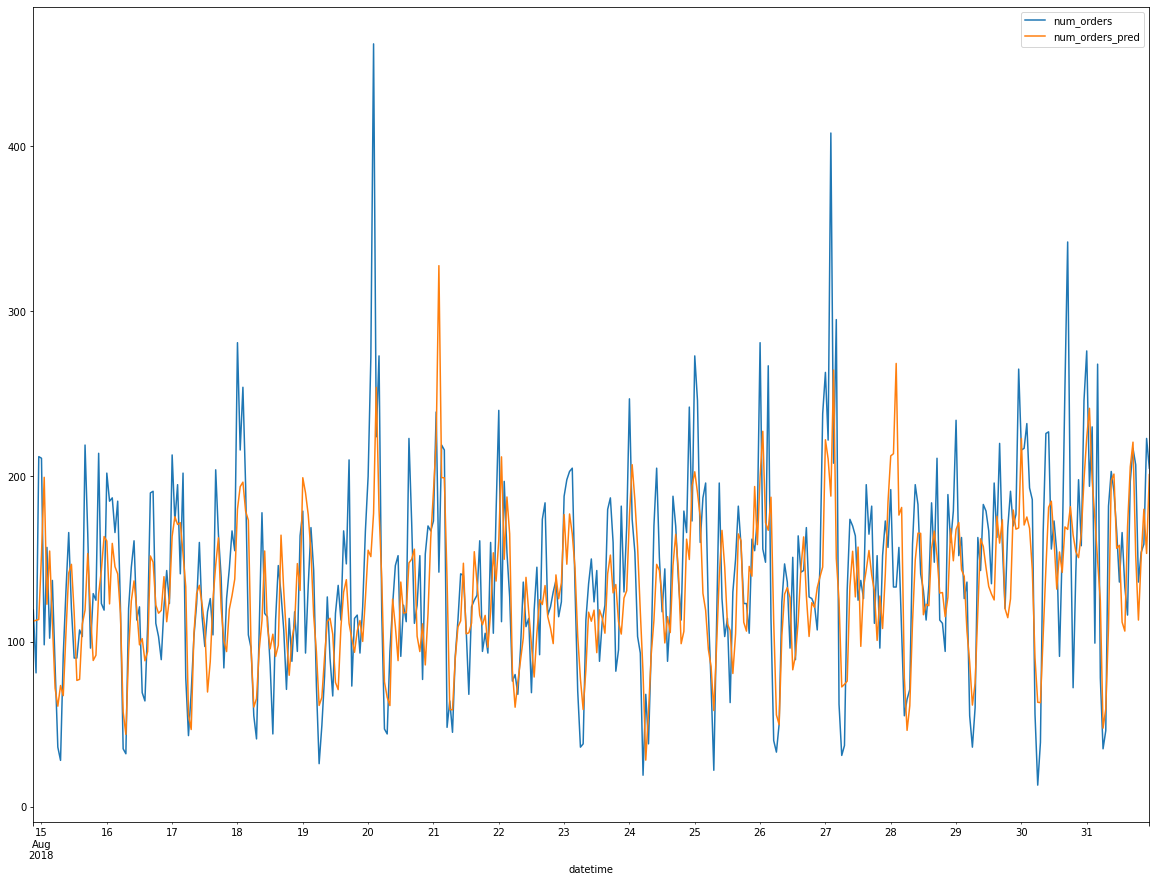

In [40]:
y_true_plot.plot(figsize=(20, 15))

У моделей часто завышение предсказаний на пиках, а так же переодически предсказание отстает от факта разительным образом(между 17-18 например)